In [2]:
import sqlite3
import pandas as pd
import numpy as np
from lxml import etree
import seaborn as sns
import matplotlib.pyplot as plt

#### PIT II > Objetivo - criar um data lake com dados em nuvem, transformar esses dados e utilizar em um PowerBI dashboard.
##### Dados do site Kaggle, nome do banco [European Soccer Database][datasource].
##### Nesse arquivo os dados são extraídos do arquivo sqlite e transformados em tabelas comma separated value (CSV).
[datasource]: https://www.kaggle.com/datasets/hugomathien/soccer

In [24]:
# Variável para alocar o banco de dados, localmente
data = sqlite3.connect('C:\\Users\\tiago\\OneDrive\\Education\\Diploma\\SupervisedMachineLearning\\DataSets\\EuropeanSoccerDatabase\\database.sqlite')

In [25]:
# Primeira tabela "league" com a junção de coluna nome do país da tabela original country
league = pd.read_sql("""
                     SELECT 
                     League.id AS league_id 
                   , League.name AS league_name
                   , Country.name AS country
                     FROM League
                          JOIN Country ON Country.id=League.country_id
                     """, data)
league

,league_id,league_name,country
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy
5,13274,Netherlands Eredivisie,Netherlands
6,15722,Poland Ekstraklasa,Poland
7,17642,Portugal Liga ZON Sagres,Portugal
8,19694,Scotland Premier League,Scotland
9,21518,Spain LIGA BBVA,Spain


In [26]:
# Segunda tabela "team", conectando a coluna "league_id" para que seja a foreign key na tabela
team = pd.read_sql("""
                   SELECT 
                   Team.team_api_id AS team_id
                 , Team.team_long_name, Team.team_short_name
                 , Match.league_id
                   FROM Team
                        JOIN Match ON Match.home_team_api_id = Team.team_api_id
                   """, data)
team

,team_id,team_long_name,team_short_name,league_id
0,9987,KRC Genk,GEN,1
1,10000,SV Zulte-Waregem,ZUL,1
2,9984,KSV Cercle Brugge,CEB,1
3,9991,KAA Gent,GEN,1
4,7947,FCV Dender EH,DEN,1
...,...,...,...,...
25974,10190,FC St. Gallen,GAL,24558
25975,9824,FC Vaduz,VAD,24558
25976,9956,Grasshopper Club Zürich,GRA,24558
25977,7896,Lugano,LUG,24558


In [27]:
# A coluna league_id segue os valores originais de country_id, para facilitar mapeamos o index com 11 valores (0 a 10) e aplicamos na tabela time
mapping = dict(zip(league['league_id'], league.index))

In [28]:
team['league_id'] = team['league_id'].map(mapping)
team

,team_id,team_long_name,team_short_name,league_id
0,9987,KRC Genk,GEN,0
1,10000,SV Zulte-Waregem,ZUL,0
2,9984,KSV Cercle Brugge,CEB,0
3,9991,KAA Gent,GEN,0
4,7947,FCV Dender EH,DEN,0
...,...,...,...,...
25974,10190,FC St. Gallen,GAL,10
25975,9824,FC Vaduz,VAD,10
25976,9956,Grasshopper Club Zürich,GRA,10
25977,7896,Lugano,LUG,10


In [29]:
# Dessa forma podemos excluir o league_id e manter somente o index da tabela
league.drop('league_id', axis=1, inplace=True)
league

,league_name,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


In [30]:
# Terceira tabela "player", arrendondando altura que originalmente possui dois decimais
# e convertendo e arredondando peso, cujos valores originais são em libras
player = pd.read_sql("""
                     SELECT 
                           player_api_id AS player_id
                         , player_name
                         , DATE(birthday) AS birthday
                         , CAST(ROUND(height) AS INTEGER) AS height
                         , CAST(ROUND(weight * 0.453592) AS INTEGER) AS weight
                     FROM Player
                     """, data)
player

,player_id,player_name,birthday,height,weight
0,505942,Aaron Appindangoye,1992-02-29,183,85
1,155782,Aaron Cresswell,1989-12-15,170,66
2,162549,Aaron Doran,1991-05-13,170,74
3,30572,Aaron Galindo,1982-05-08,183,90
4,23780,Aaron Hughes,1979-11-08,183,70
...,...,...,...,...,...
11055,26357,Zoumana Camara,1979-04-03,183,76
11056,111182,Zsolt Laczko,1986-12-18,183,80
11057,36491,Zsolt Low,1979-04-29,180,70
11058,35506,Zurab Khizanishvili,1981-10-06,185,78


In [31]:
# Vamos verificar se existem dados duplicados nas tabelas que carregamos até o momento
league.duplicated().any()

False

In [32]:
player.duplicated().any()

False

In [33]:
# A tabela team possui valores duplicados
team.duplicated().any()

True

In [36]:
# Vamos testar escolhendo apenas um time da tabela
lugano = team[team['team_long_name'] == 'Lugano']
lugano

,team_id,team_long_name,team_short_name,league_id
25815,7896,Lugano,LUG,10
25825,7896,Lugano,LUG,10
25830,7896,Lugano,LUG,10
25844,7896,Lugano,LUG,10
25850,7896,Lugano,LUG,10
25856,7896,Lugano,LUG,10
25866,7896,Lugano,LUG,10
25874,7896,Lugano,LUG,10
25890,7896,Lugano,LUG,10
25899,7896,Lugano,LUG,10


In [37]:
# Utilizando o método drop duplicates para excluir os duplicados mantendo somente uma linha, teste no subset
lugano = lugano.drop_duplicates(subset='team_id', keep='first')
lugano

,team_id,team_long_name,team_short_name,league_id
25815,7896,Lugano,LUG,10


In [38]:
# Método aplicado na tabela completa
team = team.drop_duplicates(subset='team_id', keep='first')
team

,team_id,team_long_name,team_short_name,league_id
0,9987,KRC Genk,GEN,0
1,10000,SV Zulte-Waregem,ZUL,0
2,9984,KSV Cercle Brugge,CEB,0
3,9991,KAA Gent,GEN,0
4,7947,FCV Dender EH,DEN,0
...,...,...,...,...
24739,10190,FC St. Gallen,GAL,10
24918,10191,FC Thun,THU,10
25100,9777,Servette FC,SER,10
25105,7730,FC Lausanne-Sports,LAU,10


In [39]:
# Verificar se ainda resta algum duplicado
team.duplicated().any()

False

In [40]:
# Salvando as tabelas em CSV
league.to_csv('league.csv')
team.to_csv('team.csv', index=False)
player.to_csv('player.csv', index=False)

In [103]:
# Proxima as próximas tabelas, utilizando JOIN para identificar corretamente o id de cada clube
# As colunas de eventos estão salvas em XML, com informações separadas por tags, serão tratadas na sequência
matches = pd.read_sql_query("""
                            SELECT Match.match_api_id AS match_id
                                 , Match.season
                                 , Match.home_team_api_id AS home_team_id 
                                 , Match.away_team_api_id AS away_team_id
                                 , Match.home_team_goal
                                 , Match.away_team_goal 
                                 , Match.goal, Match.shoton
                                 , Match.shotoff, Match.foulcommit, Match.card 
                                 , Match.cross, Match.corner, Match.possession
                            FROM Match
                                 JOIN Team AS HomeTeam ON Match.home_team_api_id = HomeTeam.team_api_id
                                 JOIN Team AS AwayTeam ON Match.away_team_api_id = AwayTeam.team_api_id
                            WHERE 1=1;            
                            """, data)
matches

,match_id,season,home_team_id,away_team_id,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,492473,2008/2009,9987,9993,1,1,None,None,None,None,None,None,None,None
1,492474,2008/2009,10000,9994,0,0,None,None,None,None,None,None,None,None
2,492475,2008/2009,9984,8635,0,3,None,None,None,None,None,None,None,None
3,492476,2008/2009,9991,9998,5,0,None,None,None,None,None,None,None,None
4,492477,2008/2009,7947,9985,1,3,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,1992091,2015/2016,10190,10191,1,0,None,None,None,None,None,None,None,None
25975,1992092,2015/2016,9824,10199,1,2,None,None,None,None,None,None,None,None
25976,1992093,2015/2016,9956,10179,2,0,None,None,None,None,None,None,None,None
25977,1992094,2015/2016,7896,10243,0,0,None,None,None,None,None,None,None,None


In [104]:
# Para a tabela "match" basta excluir os eventos
match = matches.drop(columns={
    'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'
})
match

,match_id,season,home_team_id,away_team_id,home_team_goal,away_team_goal
0,492473,2008/2009,9987,9993,1,1
1,492474,2008/2009,10000,9994,0,0
2,492475,2008/2009,9984,8635,0,3
3,492476,2008/2009,9991,9998,5,0
4,492477,2008/2009,7947,9985,1,3
...,...,...,...,...,...,...
25974,1992091,2015/2016,10190,10191,1,0
25975,1992092,2015/2016,9824,10199,1,2
25976,1992093,2015/2016,9956,10179,2,0
25977,1992094,2015/2016,7896,10243,0,0


In [105]:
match.to_csv('match.csv', index=False)

Para a sequência será utilizado um código para parsear as colunas em XML, esse código também está acessível no [Kaggle][codesource].

[codesource]: https://www.kaggle.com/code/njitram/exploring-the-incident-data

In [106]:
# Para cada elemento dentro da linha, indentifique a tag e o valor
def value_from_xpath(element, xpath, to_int=False, index=1):
    try:
        result = element.xpath(xpath)[index-1].text
        if to_int:
            return int(result)
        else:
            return result
    except IndexError:
        return np.nan

In [107]:
# Selecione os valores conforme a tag indicada 
def node_to_dataframe_possession(n, key):
    return pd.DataFrame({
        "away_team_poss": value_from_xpath(n, "./awaypos"),
        "home_team_poss": value_from_xpath(n, "./homepos")
        }, index=[0])

In [108]:
# Declarando uma lista para os elementos, parseando cada item na coluna possession e incrementando os valores, conforme match_id
possession_incidents = []

for key in ["possession"]:
    for _, items in matches.iterrows():
        if pd.notnull(items[key]):
            xml = etree.fromstring(items[key])
            for n in xml.xpath("/" + key + "/value"):
                df = node_to_dataframe_possession(n, key)
                df["match_id"] = items["match_id"]
                possession_incidents.append(df)

In [109]:
# Concatenando os dados dentro de uma nova tabela
possession_set = pd.concat(possession_incidents, ignore_index=True)
possession_set

,away_team_poss,home_team_poss,match_id
0,44,56,489042
1,46,54,489042
2,46,54,489042
3,45,55,489042
4,35,65,489043
...,...,...,...
34810,55,45,2030170
34811,41,59,2030171
34812,39,61,2030171
34813,40,60,2030171


In [110]:
# Selecione os valores conforme a tag indicada
def node_to_dataframe_events(n, key):
    return pd.DataFrame({
        "event_name": value_from_xpath(n, "./type"),
        "event_type": value_from_xpath(n, "./subtype"),
        "player1": value_from_xpath(n, "./player1"),
        "player2": value_from_xpath(n, "./player2"),
        "elapsed": value_from_xpath(n, "./elapsed", to_int=True),
        "team": value_from_xpath(n, "./team")
        }, index=[0])

In [111]:
# Declarando uma lista para os elementos, parseando cada item nas respectivas colunas e incrementando os valores, conforme match_id
incidents = []

for key in ["goal", "card", "foulcommit", "shoton", "shotoff", "cross", "corner"]:
    for _, items in matches.iterrows():
        if pd.notnull(items[key]):
            xml = etree.fromstring(items[key])
            for n in xml.xpath("/" + key + "/value"):
                df = node_to_dataframe_events(n, key)
                df["match_id"] = items["match_id"]
                incidents.append(df)

In [112]:
# Concatenando os dados dentro de uma nova tabela
match_event = pd.concat(incidents, ignore_index=True)
match_event

,event_name,event_type,player1,player2,elapsed,team,match_id
0,goal,header,37799,38807,22,10261,489042
1,goal,shot,24148,24154,24,10260,489042
2,goal,shot,26181,39297,4,9825,489043
3,goal,distance,30853,30889,83,8650,489044
4,goal,shot,23139,36394,4,8654,489045
...,...,...,...,...,...,...,...
882995,corner,short_left,36130,NaN,44,8370,2030171
882996,corner,cross_left,498033,NaN,49,8558,2030171
882997,corner,short_right,498033,NaN,50,8558,2030171
882998,corner,cross_left,498033,NaN,73,8558,2030171


Próximo passo é uma breve checagem nos dados, verificando integridade.

In [114]:
# Verificar se o tamanho das tabelas
print("Tables size\n"
      "League:",league.shape,"\n"
      "Team:",team.shape,"\n"
      "Player:",player.shape,"\n"
      "Match:",match.shape,"\n"
      "Possession:",possession_set.shape,"\n"
      "Match Event:",match_event.shape
     )

Tables size
League: (11, 2) 
Team: (25979, 4) 
Player: (11060, 5) 
Match: (25979, 6) 
Possession: (34815, 3) 
Match Event: (883000, 7)


In [115]:
# Verificar qual o tipo de dados de cada tabela
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   league_name  11 non-null     object
 1   country      11 non-null     object
dtypes: object(2)
memory usage: 308.0+ bytes


In [116]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team_id          25979 non-null  int64 
 1   team_long_name   25979 non-null  object
 2   team_short_name  25979 non-null  object
 3   league_id        25979 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 812.0+ KB


In [117]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_id    11060 non-null  int64 
 1   player_name  11060 non-null  object
 2   birthday     11060 non-null  object
 3   height       11060 non-null  int64 
 4   weight       11060 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 432.2+ KB


In [118]:
match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   match_id        25979 non-null  int64 
 1   season          25979 non-null  object
 2   home_team_id    25979 non-null  int64 
 3   away_team_id    25979 non-null  int64 
 4   home_team_goal  25979 non-null  int64 
 5   away_team_goal  25979 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.2+ MB


In [119]:
possession_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815 entries, 0 to 34814
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   away_team_poss  34796 non-null  object
 1   home_team_poss  34796 non-null  object
 2   match_id        34815 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 816.1+ KB


In [120]:
match_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883000 entries, 0 to 882999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  883000 non-null  object
 1   event_type  718097 non-null  object
 2   player1     857319 non-null  object
 3   player2     207966 non-null  object
 4   elapsed     883000 non-null  int64 
 5   team        881841 non-null  object
 6   match_id    883000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 47.2+ MB


In [121]:
# A tabela "possession" deveria ter todas as colunas como integer, porém são strings
# Há linhas em branco, que não deveriam existir, serão tratados em outro arquivo
print(possession_set['home_team_poss'].isnull().sum().max())
print(possession_set['away_team_poss'].isnull().sum().max())

19
19


In [122]:
# Primeiro vamos analisar os dados que temos, excluindo os valores faltantes
plot_sample = possession_set.dropna()
plot_sample

,away_team_poss,home_team_poss,match_id
0,44,56,489042
1,46,54,489042
2,46,54,489042
3,45,55,489042
4,35,65,489043
...,...,...,...
34810,55,45,2030170
34811,41,59,2030171
34812,39,61,2030171
34813,40,60,2030171


In [123]:
# Transformando os dados em integer para poder visualizar e transformar os dados
plot_sample.loc[:, ['away_team_poss', 'home_team_poss']] = plot_sample.loc[:, ['away_team_poss', 'home_team_poss']].apply(lambda x: x.astype('int64'))

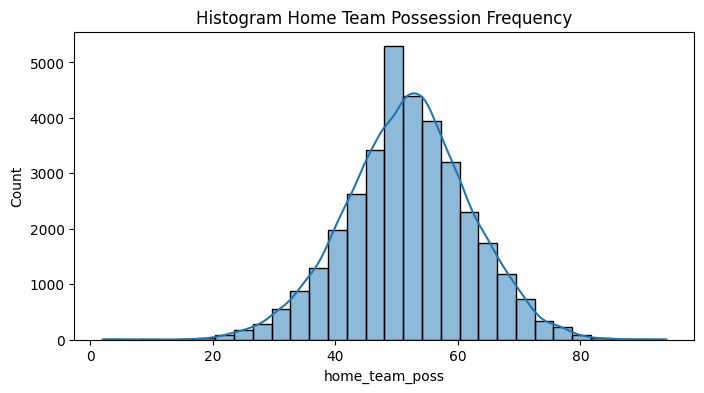

In [124]:
# Plotando os dados em um gráfico para visualizar a ocorrência dos dados
plt.figure(figsize=(8, 4))

plt.subplot()
sns.histplot(plot_sample['home_team_poss'], bins=30, kde=True)
plt.title("Histogram Home Team Possession Frequency")
plt.show()

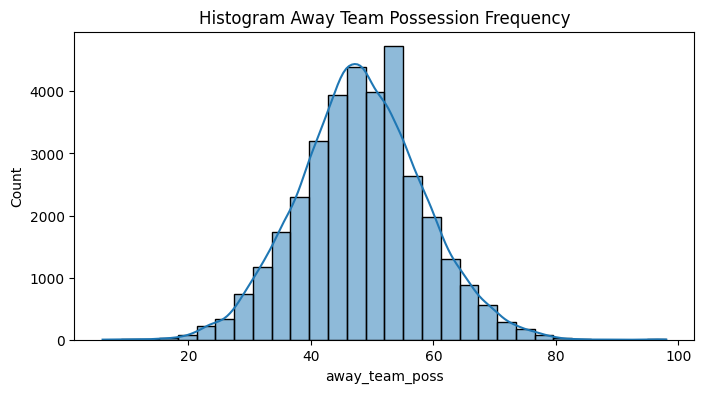

In [125]:
plt.figure(figsize=(8, 4))

plt.subplot()
sns.histplot(plot_sample['away_team_poss'], bins=30, kde=True)
plt.title("Histogram Away Team Possession Frequency")
plt.show()

Trata-se de dados numéricos contínuos, cuja distribuição é simétrica, nessa situação os valores seguem um padrão.  
Os valores faltantes são apenas 19 e podem ser corrigidos por um interpolação, para que não causem impacto.

In [126]:
# Verificando quais dados estão faltando
possession_set.loc[possession_set['away_team_poss'].isna()]

,away_team_poss,home_team_poss,match_id
186,NaN,NaN,489170
6842,NaN,NaN,1229357
6999,NaN,NaN,1229402
7178,NaN,NaN,1229438
7214,NaN,NaN,1229448
7386,NaN,NaN,1229491
7529,NaN,NaN,1228377
7765,NaN,NaN,1474327
9109,NaN,NaN,1474212
9642,NaN,NaN,1724160


In [127]:
# Visualizando duas partes específicas da tabela, para comparação posterior
possession_set[(possession_set['match_id'] == 489170) | (possession_set['match_id'] == 1051814)]

,away_team_poss,home_team_poss,match_id
185,58,42,489170
186,NaN,NaN,489170
187,53,47,489170
188,51,49,489170
31067,32,68,1051814
31068,NaN,NaN,1051814
31069,43,57,1051814
31070,43,57,1051814
31071,45,55,1051814


In [129]:
# Aplicando o método numeric, para que seja possível interpolar informação aonde não há dados
possession_set[['home_team_poss', 'away_team_poss']] = (
    possession_set[['home_team_poss', 'away_team_poss']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
)


In [130]:
# Ao aplicar o método numeric as colunas com dados faltantes passam a ter o tipo "float", permitindo a interpolação
possession = possession_set.interpolate()

In [131]:
# Verificando se ainda existem dados em branco
print(possession['home_team_poss'].isnull().sum().max())
print(possession['away_team_poss'].isnull().sum().max())

0
0


In [132]:
# Visualizando como ficou a situação após a interpolação, nas linhas 186 e 31068
possession[(possession['match_id'] == 489170) | (possession['match_id'] == 1051814)]

,away_team_poss,home_team_poss,match_id
185,58.0,42.0,489170
186,55.5,44.5,489170
187,53.0,47.0,489170
188,51.0,49.0,489170
31067,32.0,68.0,1051814
31068,37.5,62.5,1051814
31069,43.0,57.0,1051814
31070,43.0,57.0,1051814
31071,45.0,55.0,1051814


In [133]:
# Mudando o tipo de dado de float para integer nas colunas em que ocorreu interpolação
possession.loc[:, ['away_team_poss', 'home_team_poss']] = (
    possession.loc[:, ['away_team_poss', 'home_team_poss']].apply(lambda x: x.astype('int64'))
)

In [134]:
# Salvando o arquivo CSV
possession.to_csv('possession.csv', index=False)

In [135]:
# A tabela "match_event" possui as colunas player1, player2 e team como strings, mas também deveriam ser números
# Existem dados em branco, em player1 e player2 a situação é regular, já que existem eventos que não contam com essa informação
# Para a coluna team vamos aprofundar a checagem
print(match_event['player1'].isnull().sum().max())
print(match_event['player2'].isnull().sum().max())
print(match_event['team'].isnull().sum().max())

25681
675034
1159


In [136]:
# Verificando os eventos que não há dados de team, 1159 linhas com dados faltantes
# Ainda há dados que deveriam ter ao menos player1 identificado, mas estão null
sample = match_event.loc[match_event['team'].isna()]
sample

,event_name,event_type,player1,player2,elapsed,team,match_id
4088,goal,NaN,NaN,NaN,43,NaN,1026075
4845,goal,NaN,NaN,NaN,45,NaN,1229359
5020,goal,NaN,NaN,NaN,45,NaN,1228306
5946,goal,NaN,NaN,NaN,46,NaN,1474450
6104,goal,NaN,NaN,NaN,41,NaN,1475015
...,...,...,...,...,...,...,...
876732,corner,short_left,NaN,NaN,90,NaN,1778252
878601,corner,cross_left,NaN,NaN,63,NaN,1778071
880630,corner,short_left,NaN,NaN,61,NaN,2030373
882156,corner,cross_right,NaN,NaN,24,NaN,2030513


In [137]:
# Vamos agregar a tabela mais informações para verificar a situação, da tabela match vamos pegar time e temporada
sample = sample.merge(match[['match_id', 'home_team_id', 'season']], on='match_id', how='left')
sample

,event_name,event_type,player1,player2,elapsed,team,match_id,home_team_id,season
0,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012
1,goal,NaN,NaN,NaN,45,NaN,1229359,8668,2012/2013
2,goal,NaN,NaN,NaN,45,NaN,1228306,10003,2012/2013
3,goal,NaN,NaN,NaN,46,NaN,1474450,9826,2013/2014
4,goal,NaN,NaN,NaN,41,NaN,1475015,10252,2013/2014
...,...,...,...,...,...,...,...,...,...
1154,corner,short_left,NaN,NaN,90,NaN,1778252,8315,2014/2015
1155,corner,cross_left,NaN,NaN,63,NaN,1778071,10205,2014/2015
1156,corner,short_left,NaN,NaN,61,NaN,2030373,10205,2015/2016
1157,corner,cross_right,NaN,NaN,24,NaN,2030513,8558,2015/2016


In [138]:
# Mudando o nome da coluna home_team_id somente para team_id, para agregar mais um coluna
sample.rename(columns={'home_team_id': 'team_id'}, inplace=True)

In [139]:
# Agregando league_id para verificar qual a liga com dados faltantes
sample = sample.merge(team[['team_id', 'league_id']], on='team_id', how='left')
sample

,event_name,event_type,player1,player2,elapsed,team,match_id,team_id,season,league_id
0,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
1,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
2,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
3,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
4,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
...,...,...,...,...,...,...,...,...,...,...
135215,corner,cross_left,NaN,NaN,15,NaN,2030516,9864,2015/2016,9
135216,corner,cross_left,NaN,NaN,15,NaN,2030516,9864,2015/2016,9
135217,corner,cross_left,NaN,NaN,15,NaN,2030516,9864,2015/2016,9
135218,corner,cross_left,NaN,NaN,15,NaN,2030516,9864,2015/2016,9


In [140]:
# Retirando os dados duplicados
sample = sample.drop_duplicates(subset='match_id', keep='first')
sample

,event_name,event_type,player1,player2,elapsed,team,match_id,team_id,season,league_id
0,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
152,goal,NaN,NaN,NaN,45,NaN,1229359,8668,2012/2013,1
304,goal,NaN,NaN,NaN,45,NaN,1228306,10003,2012/2013,1
399,goal,NaN,NaN,NaN,46,NaN,1474450,9826,2013/2014,1
456,goal,NaN,NaN,NaN,41,NaN,1475015,10252,2013/2014,1
...,...,...,...,...,...,...,...,...,...,...
133088,corner,cross_left,NaN,NaN,2,NaN,2060555,9875,2015/2016,4
133238,corner,cross_left,NaN,NaN,22,NaN,1983415,9791,2015/2016,5
134346,corner,short_left,NaN,NaN,28,NaN,1778233,8315,2014/2015,9
134498,corner,short_left,NaN,NaN,90,NaN,1778252,8315,2014/2015,9


In [141]:
# Com o resultado verifica-se que há dados faltantes em quase todas as ligas
sample['league_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

In [142]:
league

,league_name,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


In [143]:
# Premier League inglesa, por exemplo, possui 280 linhas com informações faltantes
sample[sample['league_id']==1]

,event_name,event_type,player1,player2,elapsed,team,match_id,team_id,season,league_id
0,goal,NaN,NaN,NaN,43,NaN,1026075,8472,2011/2012,1
152,goal,NaN,NaN,NaN,45,NaN,1229359,8668,2012/2013,1
304,goal,NaN,NaN,NaN,45,NaN,1228306,10003,2012/2013,1
399,goal,NaN,NaN,NaN,46,NaN,1474450,9826,2013/2014,1
456,goal,NaN,NaN,NaN,41,NaN,1475015,10252,2013/2014,1
...,...,...,...,...,...,...,...,...,...,...
127958,corner,short,NaN,NaN,59,NaN,1474973,8659,2013/2014,1
128566,corner,cross_left,NaN,NaN,90,NaN,1724023,8191,2014/2015,1
128756,corner,cross_right,NaN,NaN,5,NaN,1987035,8668,2015/2016,1
128908,corner,short_left,NaN,NaN,59,NaN,1988864,8650,2015/2016,1


Há no total, 1159 linhas em que os clubes da casa e visitante não são informados.  
Como o impacto da exclusão seria mais prejudicial que a retirada desses dados, opta-se por manter os dados, ressalvados.

In [144]:
# Vamos transformar os dados em float
match_event[['player1', 'player2', 'team']] = match_event[['player1', 'player2', 'team']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
match_event

,event_name,event_type,player1,player2,elapsed,team,match_id
0,goal,header,37799.0,38807.0,22,10261.0,489042
1,goal,shot,24148.0,24154.0,24,10260.0,489042
2,goal,shot,26181.0,39297.0,4,9825.0,489043
3,goal,distance,30853.0,30889.0,83,8650.0,489044
4,goal,shot,23139.0,36394.0,4,8654.0,489045
...,...,...,...,...,...,...,...
882995,corner,short_left,36130.0,NaN,44,8370.0,2030171
882996,corner,cross_left,498033.0,NaN,49,8558.0,2030171
882997,corner,short_right,498033.0,NaN,50,8558.0,2030171
882998,corner,cross_left,498033.0,NaN,73,8558.0,2030171


In [145]:
match_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883000 entries, 0 to 882999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   event_name  883000 non-null  object 
 1   event_type  718097 non-null  object 
 2   player1     857315 non-null  float64
 3   player2     207966 non-null  float64
 4   elapsed     883000 non-null  int64  
 5   team        881841 non-null  float64
 6   match_id    883000 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 47.2+ MB


In [146]:
match_event.to_csv('match_event.csv')